In [1]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [8]:
from IPython.display import HTML, Javascript, display
from ipywidgets import widgets

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle();"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [9]:
%%capture
cd ..

In [10]:
%load_ext autoreload
%autoreload 2

import dill
import matplotlib.pyplot as plt

from dreamcoder.domains.list.handwrittenProperties import handWrittenProperties, getHandwrittenPropertiesFromTemplates
from dreamcoder.domains.list.makeListTasks import joshTasks
from dreamcoder.domains.list.propSim import getPropertySimTasksMatrix, getPriorDistributionsOfProperties, createSimilarTasksDf


# Load relevant tasks, properties and helmholtz frontiers
tasks = joshTasks("final")
properties = getHandwrittenPropertiesFromTemplates(tasks, filterEquivalent=False)
fileName = "data/prop_sig/helmholtz_frontiers/josh_rich_enumerated_1/enumerated_0_10000.pkl"
helmholtzFrontiers = dill.load(open(fileName, "rb"))[:100]
valuesToInt = {"allFalse":0, "allTrue":1, "mixed":2}

# Compute prior probabilities (over tasks) for property values
taskPropertyMatrix = getPropertySimTasksMatrix(tasks, properties, valuesToInt)
helmholtzTasksPropertyMatrix = getPropertySimTasksMatrix([f.task for f in helmholtzFrontiers], properties, valuesToInt)
propertyToPriorDistribution = getPriorDistributionsOfProperties(properties, taskPropertyMatrix, valuesToInt)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: 'data/final_wave'

In [ ]:
taskDropdown = widgets.Dropdown(
    options=[t.name for t in tasks],
    value=tasks[0].name,
    description='Task:',
    disabled=False,
)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1,IPython.notebook.get_selected_index()+2)'))
taskDropdown.observe(run_all, names="value")

display(taskDropdown)

010_1 : list(int) -> list(int)
f([97, 7, 13, 2, 55]) = [13, 55, 97]
f([18, 35, 7, 70, 96, 74, 37, 45]) = [70, 74, 96]
f([45, 92, 5, 40, 3, 78, 81, 50, 4, 76]) = [78, 81, 92]
f([85, 89, 8, 7, 9, 44, 30, 68, 69]) = [69, 85, 89]
f([57, 15, 51, 31, 33, 61, 6]) = [51, 57, 61]
f([95, 21, 5, 1, 53, 24]) = [24, 53, 95]
f([1, 9, 88, 8, 64, 30, 6, 87]) = [64, 87, 88]
f([80, 22, 7, 4, 47, 5, 39]) = [39, 47, 80]
f([34, 16, 0, 3]) = [3, 16, 34]
f([59, 72, 98, 6, 20, 0, 58, 3, 25, 56]) = [59, 72, 98]
f([94, 83, 9, 54, 12, 4, 28, 49, 6]) = [54, 83, 94]


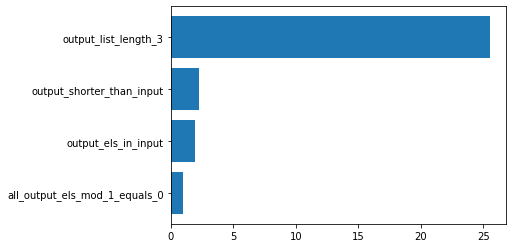

In [12]:
def getTaskIdx(taskName, tasks):
    taskIdx = [i for i,t in enumerate(tasks) if t.name == taskName]
    assert len(taskIdx) == 1
    return taskIdx[0]

taskIdx = getTaskIdx(taskDropdown.value, tasks)

_, _, sortedPropAndScores = createSimilarTasksDf(
    tasks,
    taskIdx,
    helmholtzFrontiers, 
    properties,
    helmholtzTasksPropertyMatrix, 
    propertyToPriorDistribution, 
    valuesToInt=valuesToInt,
    onlyUseTrueProperties=True,
    filterSimilarProperties=False, 
    maxFractionSame=None, 
    recomputeTasksWithTaskSpecificInputs=False, 
    computePriorFromTasks=True,
    verbose=False)

print(tasks[taskIdx].describe())

fig, ax = plt.subplots()
ax.barh([el[0].name for el in sortedPropAndScores], [1.0 / el[1] for el in sortedPropAndScores])
ax.invert_yaxis()
plt.show()